In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import pandas as pd
import time

options = Options()
options.add_experimental_option("detach", True)
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

url = "http://www.daejeonbus.or.kr/sub0503.do"

driver.get(url)

time.sleep(1)

In [2]:
# 검색어 입력
search_input = driver.find_element(By.CLASS_NAME, 'form-control')
search_input.send_keys('배차')

search_input.send_keys(Keys.RETURN)

In [3]:
# 데이터 저장을 위한 리스트
data_list = []

# 페이지당 게시물 크롤링
for page_number in range(1, 16):  # 페이지 번호 1부터 6까지
    if page_number > 1:
        # 다음 페이지로 넘어가기
        page_link = driver.find_element(By.XPATH, f"//a[span='{page_number}']")
        page_link.click()
        time.sleep(3)  # 페이지 로딩을 기다리기 위한 대기 시간
    
    # BeautifulSoup으로 HTML 파싱
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    # 첫 번째 구조의 게시물 제목 추출
    titles_write_btn = [a.get_text(strip=True) for a in soup.find_all('a', class_='write-btn')]
    
    # 두 번째 구조의 게시물 제목 추출
    titles_href = [a.get_text(strip=True) for a in soup.find_all('a', href=True) if '/sub0503view.do?boardSeq=' in a['href']]
    
    # 데이터 리스트에 추가
    data_list.extend(titles_write_btn)
    data_list.extend(titles_href)

# 데이터프레임 생성
crawling_df = pd.DataFrame(data_list, columns=['게시물 제목'])
crawling_df.head()

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//a[span='2']"}
  (Session info: chrome=116.0.5845.188); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00D037C3+48947]
	(No symbol) [0x00C98551]
	(No symbol) [0x00B9C92D]
	(No symbol) [0x00BC9E38]
	(No symbol) [0x00BC9EFB]
	(No symbol) [0x00BF8EF2]
	(No symbol) [0x00BE50D4]
	(No symbol) [0x00BF75DA]
	(No symbol) [0x00BE4E86]
	(No symbol) [0x00BC16C7]
	(No symbol) [0x00BC284D]
	GetHandleVerifier [0x00F4FDF9+2458985]
	GetHandleVerifier [0x00F9744F+2751423]
	GetHandleVerifier [0x00F91361+2726609]
	GetHandleVerifier [0x00D80680+560624]
	(No symbol) [0x00CA238C]
	(No symbol) [0x00C9E268]
	(No symbol) [0x00C9E392]
	(No symbol) [0x00C910B7]
	BaseThreadInitThunk [0x764AFCC9+25]
	RtlGetAppContainerNamedObjectPath [0x77B57B1E+286]
	RtlGetAppContainerNamedObjectPath [0x77B57AEE+238]


In [4]:
import re
# 전처리
crawling_df = crawling_df[crawling_df['게시물 제목'] != '본인인증']
crawling_df.reset_index(drop = True, inplace = True)
crawling_df['버스_번호'] = crawling_df['게시물 제목'].apply(lambda title: ', '.join(re.findall(r'\b(\d{3})번?\b', title)))
crawling_df.head()

,게시물 제목,버스_번호
0,604번 배차간격 변동 최대 25분,604
1,705번 배차간격,705
2,316 배차간격좀 줄여주세요,316
3,유천동 318번 버스 배차간격,318
4,103번 수통골→동춘당의 출근시간 배차 간격 조정을 요청합니다.,103


In [5]:
bus_number_counts = crawling_df['버스_번호'].str.findall(r'\d{3}').explode().value_counts()

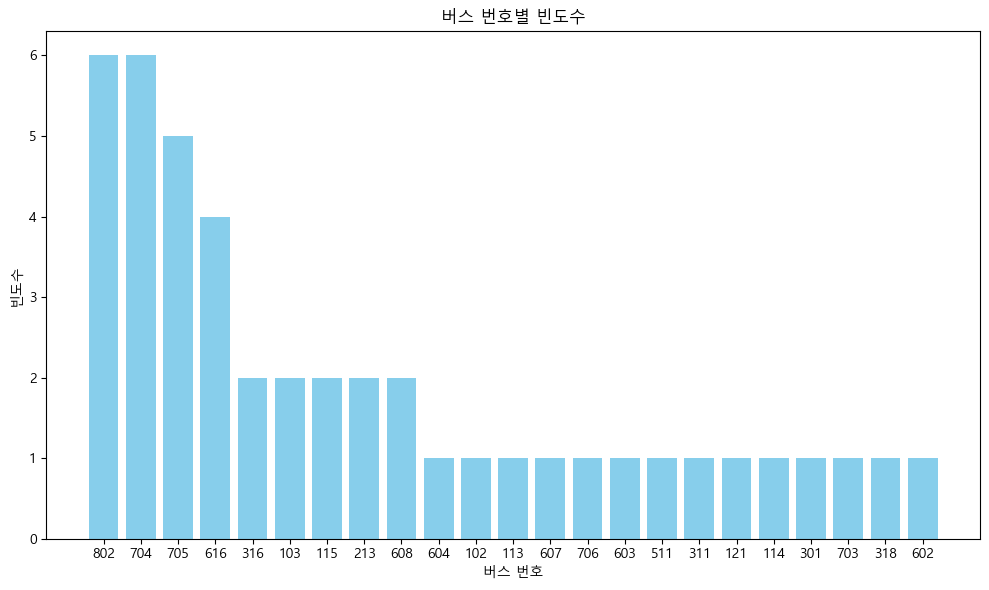

In [6]:
import matplotlib.pyplot as plt

# 데이터 준비
bus_numbers = bus_number_counts.index
counts = bus_number_counts.values

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.rc('font', family='malgun gothic')
plt.bar(bus_numbers, counts, color='skyblue')
plt.xlabel('버스 번호')
plt.ylabel('빈도수')
plt.title('버스 번호별 빈도수')
plt.xticks(rotation=0)  # x축 라벨 회전
plt.tight_layout()

# 그래프 보여주기
plt.show()

In [64]:
crawling_df = crawling_df[crawling_df['버스_번호']!='616']

In [8]:
import pandas as pd 

crawling_df = pd.read_csv('./data/crawling.csv', encoding = 'cp949')

In [9]:
import re
crawling_df = crawling_df[crawling_df['게시물 제목'] != '본인인증']
crawling_df.reset_index(drop = True, inplace = True)
# crawling_df['버스_번호'] = crawling_df['게시물 제목'].apply(lambda title: ', '.join(re.findall(r'\b(\d{3})번?\b', title)))
crawling_df.head()

,Unnamed: 0,게시물 제목
0,0,604번 배차간격 변동 최대 25분
1,1,705번 배차간격
2,2,316 배차간격좀 줄여주세요
3,3,유천동 318번 버스 배차간격
4,4,103번 수통골→동춘당의 출근시간 배차 간격 조정을 요청합니다.


In [11]:
print(crawling_df)

    Unnamed: 0                                     게시물 제목
0            0                        604번 배차간격 변동 최대 25분
1            1                                  705번 배차간격
2            2                            316 배차간격좀 줄여주세요
3            3                           유천동 318번 버스 배차간격
4            4        103번 수통골→동춘당의 출근시간 배차 간격 조정을 요청합니다.
5            5                    66번 버스 배차 시간 관련 건의드립니다.
6            6    703번 출근, (8시~9시)퇴근시간(6시~7시) 배차를 늘려주세요..
7            7                               출퇴근시간버스 배차간격
8            8                        603번버스 배차간격, 예상도착시간
9            9                                  802번 배차간격
10          10                  301 번 버스 아침 시간 배차 간격에 대하여
11          11                               103번 아침 배차간격
12          12                                    115번 배차
13          13                   114번 배차 증설 부탁드립니다.. 제발..
14          14                               121번 시내버스 배차
15          15                                     버스배차시간
16          16

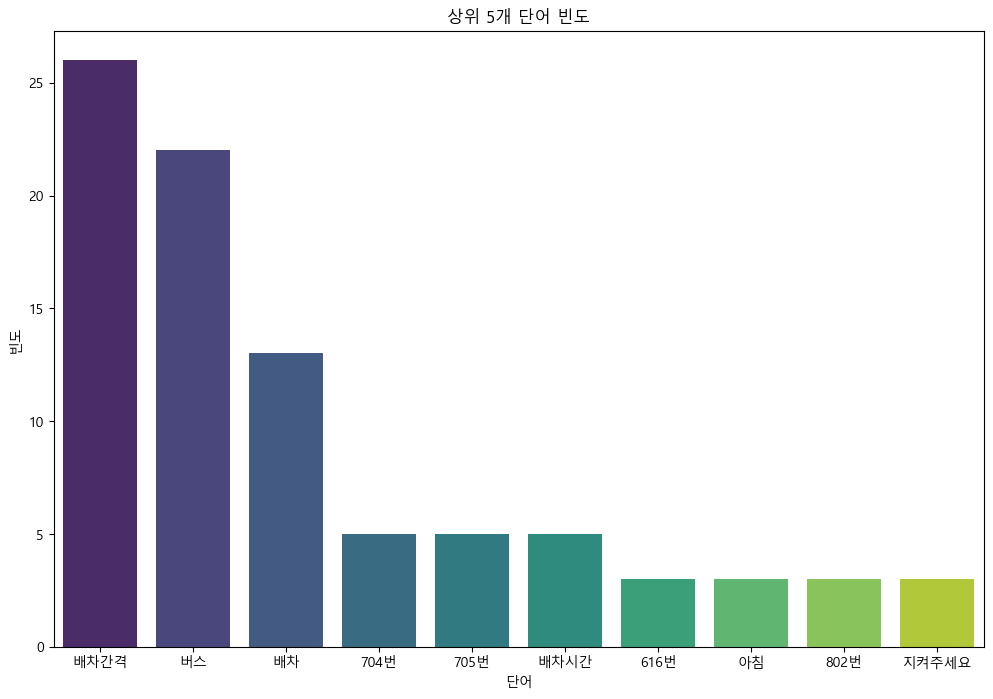

In [32]:
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

words = ' '.join(crawling_df['게시물 제목']).split()

# Count word frequency
word_count = Counter(words)

# Create a DataFrame from the word_count dictionary
word_count_df = pd.DataFrame.from_dict(word_count, orient='index', columns=['Frequency'])
word_count_df = word_count_df.reset_index().rename(columns={'index': 'Word'})

# Sort the DataFrame by frequency in descending order
word_count_df = word_count_df.sort_values(by='Frequency', ascending=False)
# word_count_df = word_count_df.iloc[3:]
plt.rc('font', family='malgun gothic')

# Create a vertical bar plot
plt.figure(figsize=(12, 8))  # Adjust the figsize for better visibility
sns.barplot(x='Word', y='Frequency', data=word_count_df.head(10), palette='viridis')
plt.xlabel('단어')
plt.ylabel('빈도')
plt.title('상위 5개 단어 빈도')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


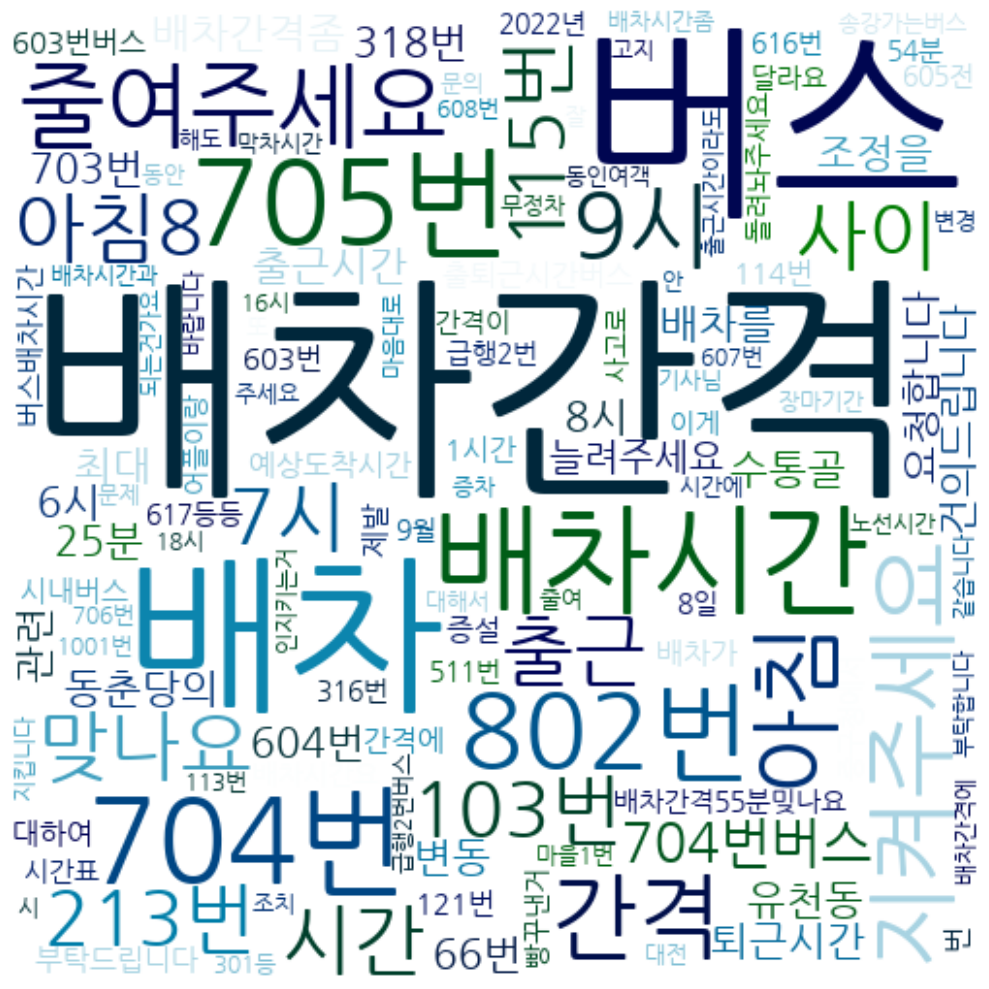

In [91]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 설정
font_path = 'C:/Users/user/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'  # 다운로드한 Nanum 폰트 파일의 경로로 변경해야 합니다.

# 게시물 제목 텍스트를 하나의 문자열로 합치기
titles_combined = ' '.join(crawling_df['게시물 제목'])

# WordCloud 객체 생성 (한글 폰트 설정 적용 및 색상 설정)
wordcloud = WordCloud(
    width=500,
    height=500,
    background_color='white',  # 투명한 배경
    font_path=font_path,
    colormap='ocean',
    contour_width=0,   # 여기에 원하는 seaborn colormap 이름을 입력합니다.
).generate(titles_combined)

# 그래프 그리기
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

# 그래프 보여주기
plt.show()